# FIT 5202 - Data processing for Big Data Assignment 2

## Submitted By : Hitesh Get
## Student ID : 29637333


## Step 01: Import Spark Session and initialize Spark

In [1]:
from pyspark import SparkContext 
from pyspark.sql import SparkSession

sc = SparkContext.getOrCreate()

if (sc is None):
    sc = SparkContext(master="local[4]", appName="Assignment 2")
spark = SparkSession(sparkContext=sc)

## Step 02: Load the dataset and print the schema and total number of entries

In [2]:
df_weatherAUS = spark.read.csv('weatherAUS.csv', header=True, inferSchema=True)

In [3]:
df_weatherAUS.show(10)

+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|               Date|Location|MinTemp|MaxTemp|Rainfall|Evaporation|Sunshine|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|Cloud9am|Cloud3pm|Temp9am|Temp3pm|RainToday|RainTomorrow|
+-------------------+--------+-------+-------+--------+-----------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+--------+--------+-------+-------+---------+------------+
|2008-12-01 00:00:00|  Albury|   13.4|   22.9|     0.6|         NA|      NA|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       8|      NA|   16.9|   21.8|

In [4]:
df_weatherAUS.printSchema

<bound method DataFrame.printSchema of DataFrame[Date: timestamp, Location: string, MinTemp: string, MaxTemp: string, Rainfall: string, Evaporation: string, Sunshine: string, WindGustDir: string, WindGustSpeed: string, WindDir9am: string, WindDir3pm: string, WindSpeed9am: string, WindSpeed3pm: string, Humidity9am: string, Humidity3pm: string, Pressure9am: string, Pressure3pm: string, Cloud9am: string, Cloud3pm: string, Temp9am: string, Temp3pm: string, RainToday: string, RainTomorrow: string]>

In [68]:
# Total Count of entries
df_weatherAUS.count()

142193

## Step 03: Delete columns from the dataset

In [5]:
drop_columns = ['Date','Location','Evaporation','Sunshine','Cloud9am','Cloud3pm','Temp9am','Temp3pm']
df_weatherAUS_new = df_weatherAUS.drop(*drop_columns)

In [6]:
df_weatherAUS_new.show(10)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|           44|         W|       WNW|          20|          24|         71|         22|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|       0|        WNW|           44|       NNW|       WSW|           4|          22|         44|         25|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|       0|        WSW|           46|         W|       WSW|          19|          26|         38|         30|     1007.6|    

## Step 04: Print the number of missing data in each column.

In [7]:
from pyspark.sql.functions import *

In [8]:
df_weatherAUS_new.select([count(when(col(each) == 'NA', each)).alias(each) for each in df_weatherAUS_new.columns]).show()

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|    637|    322|    1406|       9330|         9270|     10013|      3778|        1348|        2630|       1774|       3610|      14014|      13981|     1406|           0|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+



## Step 05: Fill the missing data with average value and maximum occurrence value.


In [11]:
# Creating a list for all the numerical columns
temp_columns = ['MinTemp','MaxTemp','Rainfall','WindGustSpeed','WindSpeed9am','WindSpeed3pm','Humidity9am','Humidity3pm','Pressure9am','Pressure3pm']

In [12]:
# Type casting the numerical columns
df_weatherAUS_new = df_weatherAUS_new.select(*(col(each).cast("double").alias(each)if each in temp_columns else each
                                               for each in df_weatherAUS_new.columns))

In [13]:
df_weatherAUS_new.printSchema

<bound method DataFrame.printSchema of DataFrame[MinTemp: double, MaxTemp: double, Rainfall: double, WindGustDir: string, WindGustSpeed: double, WindDir9am: string, WindDir3pm: string, WindSpeed9am: double, WindSpeed3pm: double, Humidity9am: double, Humidity3pm: double, Pressure9am: double, Pressure3pm: double, RainToday: string, RainTomorrow: string]>

In [14]:
df_weatherAUS_new.show(10)

+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|MinTemp|MaxTemp|Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-------+-------+--------+-----------+-------------+----------+----------+------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|   13.4|   22.9|     0.6|          W|         44.0|         W|       WNW|        20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|       No|          No|
|    7.4|   25.1|     0.0|        WNW|         44.0|       NNW|       WSW|         4.0|        22.0|       44.0|       25.0|     1010.6|     1007.8|       No|          No|
|   12.9|   25.7|     0.0|        WSW|         46.0|         W|       WSW|        19.0|        26.0|       38.0|       30.0|     1007.6|    

In [15]:
# Creating function to impute the mean value for the missing values in categorical columns
def imputer_mean(df,col_list):
    for each in col_list:
        mean_val = df.agg({each: 'mean'}).collect()[0][0]
        df = df.fillna(mean_val, subset=[each])
    return df

In [16]:
# Imputing the average valur for null values
df_weatherAUS_new = imputer_mean(df_weatherAUS_new,temp_columns)

In [17]:
df_weatherAUS_new.where(df_weatherAUS_new['MaxTemp'].isNull()).count()

0

In [18]:
df_weatherAUS_new.where(df_weatherAUS_new['Rainfall'].isNull()).count()

0

In [19]:
df_weatherAUS_new.select(df_weatherAUS_new['RainToday']).groupBy('RainToday').count().sort(desc("count")).collect()[0][0]

'No'

In [20]:
df_weatherAUS_new.select(df_weatherAUS_new['RainToday']).groupBy('RainToday').count().sort(desc("count")).collect()

[Row(RainToday='No', count=109332),
 Row(RainToday='Yes', count=31455),
 Row(RainToday='NA', count=1406)]

In [21]:
col_mode = df_weatherAUS_new.select(df_weatherAUS_new['RainToday']).groupBy('RainToday').count().sort(desc("count")).collect()[0][0]
print(col_mode)
df_weatherAUS_new_temp = df_weatherAUS_new.withColumn("RainToday", \
              when(df_weatherAUS_new["RainToday"] == "NA", col_mode).otherwise(df_weatherAUS_new["RainToday"]))

No


In [22]:
df_weatherAUS_new_temp.select(df_weatherAUS_new_temp['RainToday']).groupBy('RainToday').count().sort(desc("count")).collect()

[Row(RainToday='No', count=110738), Row(RainToday='Yes', count=31455)]

In [23]:
# Creating a function to replace null value with the mode value for non numerical columns
def mode(df,col_list1):
    for each in col_list1:
        col_mode = df.select(df[each]).groupBy(each).count().sort(desc("count")).collect()[0][0]
        #print(col_mode)
        df = df.withColumn(each,when(df_weatherAUS_new[each] == "NA", col_mode).otherwise(df[each]))
    return df

In [24]:
# Creating a list for the non numerical columns
str_cols = ['WindGustDir','WindDir9am','WindDir3pm','RainToday']

In [25]:
# Imputing the mode value for the null values in non categorical columns
df_weatherAUS_new = mode(df_weatherAUS_new,str_cols)

In [26]:
df_weatherAUS_new.printSchema

<bound method DataFrame.printSchema of DataFrame[MinTemp: double, MaxTemp: double, Rainfall: double, WindGustDir: string, WindGustSpeed: double, WindDir9am: string, WindDir3pm: string, WindSpeed9am: double, WindSpeed3pm: double, Humidity9am: double, Humidity3pm: double, Pressure9am: double, Pressure3pm: double, RainToday: string, RainTomorrow: string]>

## Step 06: Data transformation

In [32]:
# Importing pypsark machine learning module functions
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer,OneHotEncoderEstimator,VectorAssembler

# Creating an empty list
levels = []


# Running loop for encoding categorical columns
for c in str_cols:
    indexers = StringIndexer(inputCol=c, outputCol=c+"_index")
    encoders = OneHotEncoderEstimator(inputCols=[indexers.getOutputCol()], outputCols = [c+"_ohe"])
    levels += [indexers,encoders]

# Converting the label using string indexer
label_indexer = StringIndexer(inputCol = 'RainTomorrow', outputCol = 'label')
levels += [label_indexer]

# Using the vector assembler to generate one single vector column from all the feature columns
input_assemble = [c + "_ohe" for c in str_cols] + temp_columns

assembler = VectorAssembler(inputCols=input_assemble, outputCol="features")
levels += [assembler]


In [33]:
print(temp_columns)

['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm']


## Step 07: Create the feature vector and divide the dataset

In [34]:
# Creating a pipeline to combine transformers and estimators
pipeline = Pipeline(stages=levels)
# Fitting the pipeline model
pipeline_model = pipeline.fit(df_weatherAUS_new)
# Transforming and cerating new data frame
df_weatherAUS_new_transormed = pipeline_model.transform(df_weatherAUS_new)
# Adding faetures and labels columns to the transformed dataframe
cols = df_weatherAUS_new.columns
cols_selected = ['label', 'features'] + cols
df_weatherAUS_new_transormed = df_weatherAUS_new_transormed.select(cols_selected)
df_weatherAUS_new_transormed.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- MinTemp: double (nullable = false)
 |-- MaxTemp: double (nullable = false)
 |-- Rainfall: double (nullable = false)
 |-- WindGustDir: string (nullable = true)
 |-- WindGustSpeed: double (nullable = false)
 |-- WindDir9am: string (nullable = true)
 |-- WindDir3pm: string (nullable = true)
 |-- WindSpeed9am: double (nullable = false)
 |-- WindSpeed3pm: double (nullable = false)
 |-- Humidity9am: double (nullable = false)
 |-- Humidity3pm: double (nullable = false)
 |-- Pressure9am: double (nullable = false)
 |-- Pressure3pm: double (nullable = false)
 |-- RainToday: string (nullable = true)
 |-- RainTomorrow: string (nullable = true)



In [35]:
df_weatherAUS_new_transormed.show(50)

+-----+--------------------+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|label|            features|MinTemp|MaxTemp|          Rainfall|WindGustDir|WindGustSpeed|WindDir9am|WindDir3pm|   WindSpeed9am|WindSpeed3pm|Humidity9am|Humidity3pm|Pressure9am|Pressure3pm|RainToday|RainTomorrow|
+-----+--------------------+-------+-------+------------------+-----------+-------------+----------+----------+---------------+------------+-----------+-----------+-----------+-----------+---------+------------+
|  0.0|(56,[0,21,37,45,4...|   13.4|   22.9|               0.6|          W|         44.0|         W|       WNW|           20.0|        24.0|       71.0|       22.0|     1007.7|     1007.1|       No|          No|
|  0.0|(56,[9,24,33,45,4...|    7.4|   25.1|               0.0|        WNW|         44.0|       NNW|       WSW|            4.0|        22.0|       44.0|

In [36]:
# Splitting the data into train ans test data
train_data, test_data = df_weatherAUS_new_transormed.randomSplit([0.7, 0.3], seed = 1234)

## Step 08 and Step 09: Apply machine learning classification algorithms on the dataset and compare their accuracy. Plot the accuracy as bar graph. Calculate the confusion matrix and find the precision, recall, and F1 score of each classification algorithm.

## Decision Tree

In [80]:
# importing the machine learning modules
from pyspark.ml.classification import DecisionTreeClassifier

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Creating an empty dictionary to capture all ML model accuracies
model_accuracy = {}

# Implementing decision tree and fitting the model
dt = DecisionTreeClassifier(labelCol="label", featuresCol="features",maxDepth = 3)
model_dt = dt.fit(train_data)

# Transorming the data
predictions_dt = model_dt.transform(test_data)

# Displaying the predictions
predictions_dt.select("prediction","rawPrediction", "label","probability").show(20)

# Creating the evaluator to calculate the model accuracy
evaluator_dt = MulticlassClassificationEvaluator(\

labelCol="label", predictionCol="prediction",\

metricName="accuracy")

accuracy_dt = evaluator_dt.evaluate(predictions_dt)

print(" The accuracy of decision tree model is " + str(accuracy_dt))

model_accuracy["Decision Tree"] = accuracy_dt

print(model_accuracy)
               

print("Test Error = %g " % (1.0 - accuracy_dt))

+-------+----------+-----------------+-----+--------------------+
|MaxTemp|prediction|    rawPrediction|label|         probability|
+-------+----------+-----------------+-----+--------------------+
|   19.3|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   19.1|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   18.9|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   18.7|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   28.7|       0.0|  [3526.0,2262.0]|  0.0|[0.60919143054595...|
|   21.3|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   26.2|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   22.4|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   22.8|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   26.8|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   28.2|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   27.7|       0.0|[70880.0,12131.0]|  0.0|[0.85386274108250...|
|   28.0| 

In [86]:
# Creating function to calculate confusion matrix,precision, recall and F1 score
def printMetrics(predictions_and_labels):
    metrics = MulticlassMetrics(predictions_and_labels)
    print('Confusion Matrix\n', metrics.confusionMatrix().toArray())
    c_mat=metrics.confusionMatrix().toArray()
    precision_false=(c_mat[0][0])/(c_mat[0][0]+c_mat[1][0])
    precision_true=(c_mat[1][1])/(c_mat[1][1]+c_mat[0][1])    
    recall_false=(c_mat[0][0])/(c_mat[0][0]+c_mat[0][1])
    recall_true=(c_mat[1][1])/(c_mat[1][1]+c_mat[1][0]) 
    f1_score = (2* c_mat[0][0])/(2*c_mat[0][0]+c_mat[0][1]+c_mat[1][0])
    
    print("The precision of False is ",str(precision_false))
    print("The precision of True is ",str(precision_true))
    print("The recall of True is ",str(recall_true))
    print("The recall of False is ",str(recall_false))
    print("The F1-score is ",str(f1_score))

In [87]:
# Creating prediction and label rdd
predictionAndLabel_dt = predictions_dt.select("prediction", "label").rdd
printMetrics(predictionAndLabel_dt)

Confusion Matrix
 [[32046.  1136.]
 [ 6164.  3424.]]
The precision of False is  0.838680973567129
The precision of True is  0.7508771929824561
The recall of True is  0.3571130579891531
The recall of False is  0.9657645711530348
0.8977476467951591
The F1-score is  0.8977476467951592


## Random Forest

In [88]:
# importing the machine learning modules
from pyspark.ml.classification import RandomForestClassifier

# Creating a random forest model
rf = RandomForestClassifier(labelCol="label",\
featuresCol="features", numTrees=10)

# Fitting the model
model_rf = rf.fit(train_data)

# Transforming the data
predictions_rf = model_rf.transform(test_data)

predictions_rf.select("prediction", "label","rawPrediction","probability").show(10)

# Evaluating model performance
evaluator_rf =\
MulticlassClassificationEvaluator(labelCol="label",\
predictionCol="prediction", metricName="accuracy")

# Calculating model accuracy
accuracy_rf = evaluator_rf.evaluate(predictions_rf)

print("The random forest model accuracy is:"+ str(accuracy_rf))

model_accuracy["Random Forest"] = accuracy_rf

print("Test Error = %g" % (1.0 - accuracy_rf))


+----------+-----+
|prediction|label|
+----------+-----+
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
|       0.0|  0.0|
+----------+-----+
only showing top 10 rows

The random forest model accuracy is:0.8283610007014263
Test Error = 0.171639


In [89]:
# Creating perdiction and label rdd
predictionAndLabel_rf = predictions_rf.select("prediction", "label").rdd
printMetrics(predictionAndLabel_rf)

Confusion Matrix
 [[32320.   862.]
 [ 6479.  3109.]]
The precision of False is  0.8330111600814454
The precision of True is  0.782926215059179
The recall of True is  0.32425949103045476
The recall of False is  0.974022060153095
0.8980147538933885
The F1-score is  0.8980147538933886


## Logistic Regression

In [90]:
# Importing machine learning modules
from pyspark.ml.classification import LogisticRegression
import numpy as np
import matplotlib.pyplot as plt
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Creating logistic Regression model
log_reg = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter=10)
model_lr = log_reg.fit(train_data)

# Transforming the data
predictions_lr = model_lr.transform(test_data)
 
predictions_lr.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

# Evaluating model performance
evaluator_lr =\
MulticlassClassificationEvaluator(labelCol="label",\
predictionCol="prediction", metricName="accuracy")

# Calculating model accuracy
accuracy_lr = evaluator_lr.evaluate(predictions_lr)

print("The logistic regression model accuracy is:"+ str(accuracy_lr))

model_accuracy["Logistic Regression"] = accuracy_lr

print("Test Error = %g" % (1.0 - accuracy_lr))

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[1.63146140787279...|       0.0|[0.83636973866221...|
|  0.0|[0.90531326451071...|       0.0|[0.71204015511253...|
|  0.0|[1.26671843689595...|       0.0|[0.78018048092537...|
|  0.0|[0.64546712329793...|       0.0|[0.65598826350991...|
|  0.0|[1.01230890011041...|       0.0|[0.73347176153072...|
|  0.0|[1.06551462828954...|       0.0|[0.74374298673333...|
|  0.0|[0.97995508681246...|       0.0|[0.72709930449210...|
|  0.0|[0.88687579896153...|       0.0|[0.70824502663725...|
|  0.0|[1.06081803796338...|       0.0|[0.74284684238191...|
|  0.0|[0.99779017180217...|       0.0|[0.73062387825488...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows

The logistic regression model accuracy is:0.8183773673135375


In [66]:
# Creating prediction and label rdd
predictionAndLabel_lr = predictions_lr.select("prediction", "label").rdd
printMetrics(predictionAndLabel_lr)

Precision of True  0.6435331230283912
Precision of False 0.8488059291792479
Recall of True     0.425531914893617
Recall of False    0.9318907841600867
F-1 Score          0.8183773673135375
Confusion Matrix
 [[30922.  2260.]
 [ 5508.  4080.]]


## GBT Classifier

In [91]:
# imprting machine learning modules
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
# Creating GBT model
gbt = GBTClassifier(maxIter=10)
gbtModel = gbt.fit(train_data)

# TRansforming the data
predictions_gbt = gbtModel.transform(test_data)
predictions_gbt.select('label', 'rawPrediction', 'prediction', 'probability').show(10)

# Evaluating model performance
evaluator_gbt =\
MulticlassClassificationEvaluator(labelCol="label",\
predictionCol="prediction", metricName="accuracy")

# Calculating model accuracy
accuracy_gbt = evaluator_gbt.evaluate(predictions_gbt)

print("The GBT  model accuracy is:"+ str(accuracy_gbt))

model_accuracy["GBT"] = accuracy_gbt

print("Test Error = %g" % (1.0 - accuracy_gbt))
 
# Use explainParams() to output a list of all parameters and their definitions
print(gbt.explainParams())

+-----+--------------------+----------+--------------------+
|label|       rawPrediction|prediction|         probability|
+-----+--------------------+----------+--------------------+
|  0.0|[0.92081090920191...|       0.0|[0.86314040414413...|
|  0.0|[0.73738808367270...|       0.0|[0.81378225472440...|
|  0.0|[0.81811450921302...|       0.0|[0.83702116599149...|
|  0.0|[0.65861635163657...|       0.0|[0.78872093201948...|
|  0.0|[0.37866927172315...|       0.0|[0.68077562407350...|
|  0.0|[0.76060743809918...|       0.0|[0.82071730762759...|
|  0.0|[0.88032369457616...|       0.0|[0.85329072257786...|
|  0.0|[0.17641797641473...|       0.0|[0.58730512073999...|
|  0.0|[0.32399917012757...|       0.0|[0.65655925156790...|
|  0.0|[0.34278688528881...|       0.0|[0.66498156773402...|
+-----+--------------------+----------+--------------------+
only showing top 10 rows

The GBT  model accuracy is:0.8398643909282207
Test Error = 0.160136
cacheNodeIds: If false, the algorithm will pass tree

In [92]:
# Creating the prediction and label rdd
predictionAndLabel_gbt = predictions_gbt.select("prediction", "label").rdd
printMetrics(predictionAndLabel_gbt)

Confusion Matrix
 [[31503.  1679.]
 [ 5170.  4418.]]
The precision of False is  0.8590243503394868
The precision of True is  0.7246186649171724
The recall of True is  0.46078431372549017
The recall of False is  0.9494002772587548
0.901954047670174
The F1-score is  0.901954047670174


#### Implementing Cross Validation method to GBT for performance improvement

In [111]:
# ParamGridBuilder() used in grid search-based models
# Parametric to ParamGridBuilder.addGrid() is a pair.
paramGrid = (ParamGridBuilder()
             .addGrid(gbt.maxDepth, [2, 4, 6])
             .addGrid(gbt.maxBins, [20, 60])
             .addGrid(gbt.maxIter, [10, 20])
             .build())

# Creating cross validation model
cv = CrossValidator(estimator=gbt, estimatorParamMaps=paramGrid,    evaluator=evaluator, numFolds=5)
 
# Run cross validation
cvModel = cv.fit(train_data)
predictions_cv = cvModel.transform(test_data)

# Calculating model accuracy
accuracy_gbt_cv = evaluator_gbt.evaluate(predictions_cv)
print("The GBT  model accuracy is:"+ str(accuracy_gbt_cv))

The GBT  model accuracy is:0.8451718494271686


* Here we can see that after implementing Cross Validation Method the accuracy improved from 83% to 84%

In [94]:
predictionAndLabel_gbt_new = predictions_cv.select("prediction", "label").rdd
printMetrics(predictionAndLabel_gbt)

Confusion Matrix
 [[31503.  1679.]
 [ 5170.  4418.]]
The precision of False is  0.8590243503394868
The precision of True is  0.7246186649171724
The recall of True is  0.46078431372549017
The recall of False is  0.9494002772587548
0.901954047670174
The F1-score is  0.901954047670174


In [95]:
print(model_accuracy)

{'Decision Tree': 0.8293196165536592, 'Random Forest': 0.8283610007014263, 'Logistic Regression': 0.8183773673135375, 'GBT': 0.8398643909282207}


### Plotting model and their accuracies

In [100]:
import pandas as pd
df_model = pd.DataFrame(list(model_accuracy.items()), columns=['Model', 'Accuracy'])

In [101]:
df_model

,Model,Accuracy
0,Decision Tree,0.829320
1,Random Forest,0.828361
2,Logistic Regression,0.818377
3,GBT,0.839864


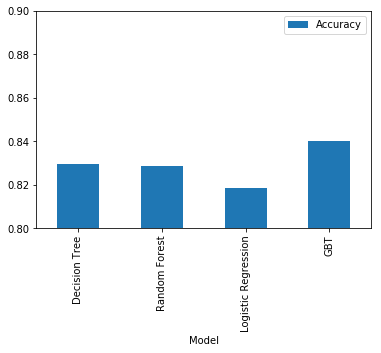

In [110]:
import matplotlib.pyplot as plt
df_model.plot(x='Model',y='Accuracy',kind='bar')
plt.ylim(0.8,0.9)
plt.show()

### Techniques to make our models perform better 

### 1. Logistic Regression

* We can use a method of bagging where we can build multiple models and then averaging the predictions. the concept of bagging was described by Leo Breiman. In this, we generate multiple dataset by taking random sample from the main dataset. Then using each of these dataset, we build logistic regression model. Finally, we take the average the probability of all logistic models to determine final probability.

### 2. Random Forest

* To increase the performance of a random forest, we can tune the model parameters. Such as increasing max_features improve the model performance as it provides higher number of options to be considered, by increasinf the values of n_estimators, higher the number of trees means better performance, increasing the min_sample_leaf size as smaller leaf size causes to capture more noise in the data.

### 3. Decision Tree 

* We can increase the accuracy of a decision tree model by increasing the min sample per leaf node which will stop the tree from classifying the outliers, we can also create a situation all the features are given a chance to become a decision node.

### 4.GBT Classifier

* we have used cross validation method above to increase the model performance

### References
* https://blog.zopa.com/2017/07/20/tips-honing-logistic-regression-models/
* https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/
* https://gallery.azure.ai/Experiment/Evaluating-and-Parameter-Tuning-a-Decision-Tree-Model-1